## MSDS 432 - Programming Assignment #10 Dan Avni

The purpose of this programming assignment is to implement a *KNN*, or K-Nearest-Neighbours classifier and apply it to the classic Iris flower dataset. 

KNN is a relatively simple, non-parametric classifier or regression algorithm. Despite its simplicity, it often provides good performance and requires little training or hyper-tuning. It is based on finding the nearest K neighbors to each data point and using the most common class of in the set, or the average response value to classify or estimate the response for the target respectively. 

A KNN classifier can either take the most common or straight mean of the K neighbors or weight the neighbors by their distance to the estimated point. Various distance function can be used, in this example we will stick to the Euclidian distance: $\sqrt{\sum_{i=1}^n(q_i-p_i)^2}$. The root of the squared sum of the coordinates in an n-dimensional space.

We have implemented a KNN classifier using a min-priority-queue approach, adding the Iris observation to queue sorted by the distance. While this may work well for such as small dataset, a more robust implementation of the algorithm needs to use a more refined approach of indexing the observations to allow faster retrieval of the K nearest neighbors.

The complexity of our solution using the Big-O notation, with $d$ as the number of dimensions, and $n$ as the number of obervations is:

$O(nd + n + klog(n))$

The three components contributing to the complexity are initializing the distance $nd$, inserting the observation to the priority queue $n$, and retrieving the k points from the queue $klog(n)$.

We executed our KNN classifier using several values of K and examined the accuracy and runtime. The results are shown in the table below. The training accuracy was near perfect as long as K was kept sufficiently low, below the Iris cluster sizes.


|   K |   accuracy |       f1 |   runtime_ms |
|----:|-----------:|---------:|-------------:|
|   1 |   0.96     | 0.96     |      39.1974 |
|   3 |   0.96     | 0.96     |      27.8184 |
|   5 |   0.966667 | 0.966663 |      30.3292 |
|   7 |   0.966667 | 0.966637 |      28.7917 |
|  10 |   0.953333 | 0.953329 |      27.4181 |
|  25 |   0.966667 | 0.966663 |      31.1141 |
|  50 |   0.946667 | 0.946581 |      38.6612 |
|  75 |   0.88     | 0.879164 |      44.0764 |
| 100 |   0.526667 | 0.479904 |      51.4123 |

### Optimal K for classification accuracy (extra credit 1)

Normally, we would not tune a model on an entire training set as it is likely to result in overfitting. Nevertheless, based on the above table and the plot below, we recommend a K value of 7 to achieve optimal accuracy and reduce classification error for the Iris training dataset.

Both the accuracy and the $F1$ score that balances precision and recall concur. 

<img width="50%" src="https://raw.githubusercontent.com/dannyavni/MSDS_432/master/knn.png"/>

### Differences from SciKit Learn KNN (extra credit 2)

There are several key differences between our simple implementation and the more complete and robust SciKit Lean KNN implementation.

1. SciKit KNN automatically selected an efficient data structure to store the observation for efficient retrieval, leveraging indexes like KDTree or BallTree for efficient space-search.

2. SciKit KNN supports multiple methods to assign a class or predicted value. While supporting the majority class or simple mean,  it allows using a distance weighted approach

3. SciKit KNN provides an additional approach: selecting all the neighbors within a fixed radius

In [1]:
#import required packages
import numpy as np
import pandas as pd
import time
from sklearn.datasets import load_iris
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from scipy.spatial import distance
from collections import Counter
import matplotlib.pyplot as plt
import heapq as hq
from tabulate import tabulate

In [2]:
iris = load_iris()
features = iris['data']
targets  = iris['target']
target_names = iris['target_names']

In [3]:
def knn_find_k(feature, targets, dist, k):
    h = []
    [hq.heappush(h, (dist[i], targets[i])) for i in range(len(dist))]
    #discard self
    hq.heappop(h) 
    return([hq.heappop(h) for i in range(k)])

def knn_append(cnt, dist, cls):
    cnt[cls] += 1

def knn_class(klist):
    cnt = Counter()
    [knn_append(cnt, klist[i][0], klist[i][1]) for i in range(len(klist))]
    return(cnt.most_common(1)[0][0])

def knn_classify(features, targets, k):
    dist = distance.cdist(features, features, 'euclidean')
    cls = []
    [cls.append(knn_class(knn_find_k(features[i], targets, dist[i], k))) for i in range(len(features))]
    return(cls)

In [4]:
test_results_col_names = ['k', 'accuracy', 'f1','runtime_ms']
test_results           = pd.DataFrame(columns = test_results_col_names) 

In [5]:
for k in [1,3,5,7,10,25,50,75,100]:
    start   = time.time()
    cls = knn_classify(features, targets, k)
    runtime_ms = ((time.time() - start) * 1000)
    test_results.loc[len(test_results)] = [k, 
                                           accuracy_score(targets, cls),
                                           f1_score(targets, cls, average = "weighted"),
                                           runtime_ms]

In [6]:
test_results

,k,accuracy,f1,runtime_ms
0,1.0,0.960000,0.960000,39.197445
1,3.0,0.960000,0.960000,27.818441
2,5.0,0.966667,0.966663,30.329227
3,7.0,0.966667,0.966637,28.791666
4,10.0,0.953333,0.953329,27.418137
5,25.0,0.966667,0.966663,31.114101
6,50.0,0.946667,0.946581,38.661242
7,75.0,0.880000,0.879164,44.076443
8,100.0,0.526667,0.479904,51.412344


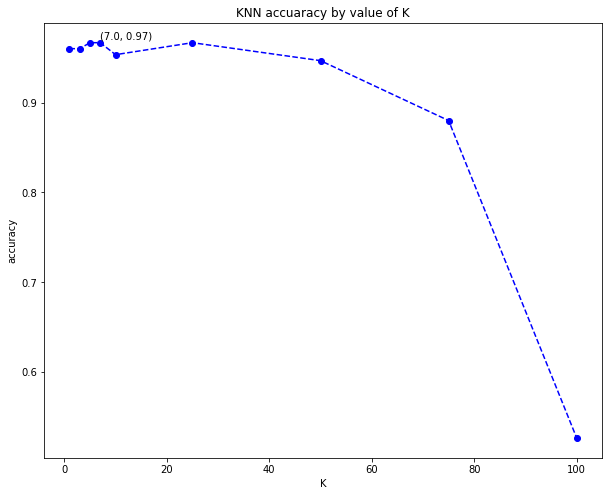

In [7]:
#plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.plot(test_results.k, test_results.accuracy, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('accuracy')
plt.title('KNN accuaracy by value of K')
row = test_results[test_results['k']==7]
xy = (round(row.values[0][0]), round(row.values[0][1], 2))
ax.annotate('(%s, %s)' % xy, xy=xy , textcoords='data')
plt.show()

In [8]:
print(tabulate(test_results, tablefmt="pipe", headers="keys"))

|    |   k |   accuracy |       f1 |   runtime_ms |
|---:|----:|-----------:|---------:|-------------:|
|  0 |   1 |   0.96     | 0.96     |      39.1974 |
|  1 |   3 |   0.96     | 0.96     |      27.8184 |
|  2 |   5 |   0.966667 | 0.966663 |      30.3292 |
|  3 |   7 |   0.966667 | 0.966637 |      28.7917 |
|  4 |  10 |   0.953333 | 0.953329 |      27.4181 |
|  5 |  25 |   0.966667 | 0.966663 |      31.1141 |
|  6 |  50 |   0.946667 | 0.946581 |      38.6612 |
|  7 |  75 |   0.88     | 0.879164 |      44.0764 |
|  8 | 100 |   0.526667 | 0.479904 |      51.4123 |
